## Import modules

In [1]:
import pickle as pkl
import numpy as np
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.utils.data
import torch.optim as optim
import gym
%matplotlib inline

## Set up data class

In [2]:
class Data:
    def __init__(self, data_file, train_ratio=0.8, batch_size=100):
        
        assert (train_ratio >= 0 and train_ratio <= 1), "train_ratio must be in the range (0,1)"
        
        self.train_ratio = train_ratio
        self.val_ratio = 1 - train_ratio
        self.batch_size = batch_size
        data = pkl.load(open(data_file, "rb"))
        
        print('Train/val split: {}/{}'.format(self.train_ratio, self.val_ratio))
        self.X_train, self.X_val, self.y_train, self.y_val = self.split_data(data)
        
        self.input_dim = self.X_train.shape[1]
        self.output_dim = self.y_train.shape[1]
        
        train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(self.X_train).float(), torch.from_numpy(self.y_train).float())
        val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(self.X_val).float(), torch.from_numpy(self.y_val).float())
        
        self.train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size)
        self.val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=self.X_val.shape[0])
        self.expert_stats = data['returns']
        
    def split_data(self, data):
        '''Split dataset into training and validation sets'''
        obs = data['observations']
        actions = np.squeeze(data['actions'])
        
        X_train, X_val, y_train, y_val = \
         train_test_split(obs, actions, test_size=self.val_ratio, random_state=42)
        print('splitting and shuffling data:')
        print('X_train.shape', X_train.shape)
        print('X_val.shape', X_val.shape)
        print('y_train.shape', y_train.shape)
        print('y_val.shape', y_val.shape)
        return X_train, X_val, y_train, y_val
    
    def get_train_val(self):
        return self.train_data_loader, self.val_data_loader

## Import expert rollout data

In [3]:
data = Data('./behavioral_cloning/expert_data/Hopper-v2_expert.pkl')
train_data_loader, val_data_loader = data.get_train_val()

Train/val split: 0.8/0.19999999999999996
splitting and shuffling data:
X_train.shape (16000, 11)
X_val.shape (4000, 11)
y_train.shape (16000, 3)
y_val.shape (4000, 3)


## Create a simple 2-layer network

In [4]:
class BCNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BCNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 20)
        self.fc2 = nn.Linear(20, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
bc_model = BCNet(data.input_dim, data.output_dim)

## Create train and test functions

In [5]:
def train(epochs, network, optimizer, loss_fn, train_loader, test_loader, testing=True):
    train_losses = []
    val_losses = []
    training_step = 0
    network.train()
    for epoch in range(1, epochs+1):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = network(data)
            loss = loss_fn(output, target)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

            training_step += 1

            if (training_step % 40 == 0) or (training_step == 1) :
                print('Epoch {}; training step {} mse: {:.3f}'.format(epoch, training_step, loss.item()))
            
        if (testing):
            val_losses.append(validate(network, test_loader, loss_fn))   
            
    return train_losses, val_losses

In [6]:
def validate(network, test_loader, loss_fn):
    loss = 0
    steps = 0
    network.eval()
    
    for batch_idx, (data, target) in enumerate(test_loader):
        output = network(data)
        loss += loss_fn(output, target).item()
        steps += 1
        
    avg_loss = loss / steps
    print('Test set mse: {:.3f}'.format(avg_loss))    
    return avg_loss

## Train and validate network

In [7]:
bc_model = BCNet(data.input_dim, data.output_dim)
optimizer = optim.Adam(bc_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
train_losses, val_losses = train(10, bc_model, optimizer, loss_fn, train_data_loader, val_data_loader)

Epoch 1; training step 1 mse: 2.710
Epoch 1; training step 40 mse: 1.805
Epoch 1; training step 80 mse: 1.489
Epoch 1; training step 120 mse: 0.904
Epoch 1; training step 160 mse: 0.724
Test set mse: 0.656
Epoch 2; training step 200 mse: 0.442
Epoch 2; training step 240 mse: 0.432
Epoch 2; training step 280 mse: 0.275
Epoch 2; training step 320 mse: 0.298
Test set mse: 0.269
Epoch 3; training step 360 mse: 0.236
Epoch 3; training step 400 mse: 0.241
Epoch 3; training step 440 mse: 0.175
Epoch 3; training step 480 mse: 0.198
Test set mse: 0.174
Epoch 4; training step 520 mse: 0.166
Epoch 4; training step 560 mse: 0.170
Epoch 4; training step 600 mse: 0.128
Epoch 4; training step 640 mse: 0.144
Test set mse: 0.128
Epoch 5; training step 680 mse: 0.130
Epoch 5; training step 720 mse: 0.130
Epoch 5; training step 760 mse: 0.102
Epoch 5; training step 800 mse: 0.112
Test set mse: 0.102
Epoch 6; training step 840 mse: 0.108
Epoch 6; training step 880 mse: 0.106
Epoch 6; training step 920 mse

## Plot training and validation data

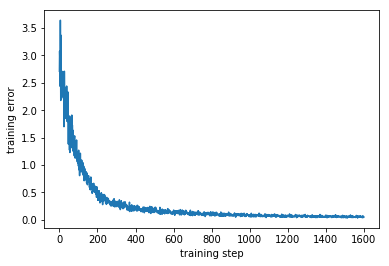

In [8]:
plt.plot(train_losses)
plt.ylabel('training error')
plt.xlabel('training step')
plt.show()

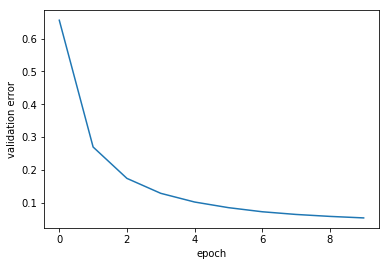

In [9]:
plt.plot(val_losses)
plt.ylabel('validation error')
plt.xlabel('epoch')
plt.show()
# note: value for epoch n signifies the loss recorded after completion of epoch n

## Test with gym env

In [10]:
def test_with_gym(policy_fn, rollouts, render, expert_stats):   
    gym.logger.set_level(40)
    random_seed=42
    env = gym.make('Hopper-v2')
    env.seed(random_seed)
    max_steps = 1000
    returns = []
    
    for i in range(rollouts):
        print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        
        while not done:
            action = policy_fn(torch.Tensor(obs)).detach().numpy()
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            
            if render:
                env.render()
            if steps % 100 == 0: 
                print("%i/%i"%(steps, max_steps))
            if steps >= max_steps:
                break
        print('Number of steps in this rollout: {}'.format(steps))
        returns.append(totalr)
        
    print('bc_model: mean of return', np.mean(returns))
    print('bc_model: std of return', np.std(returns))
    print('expert: mean of return', expert_stats['mean'])
    print('expert: std of return', expert_stats['std'])

In [11]:
rollouts = 10
render = False
random_seed = 42

test_with_gym(bc_model, rollouts, render, data.expert_stats)

/Users/slakshay/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


iter 0
Number of steps in this rollout: 96
iter 1
Number of steps in this rollout: 96
iter 2
Number of steps in this rollout: 98
iter 3
Number of steps in this rollout: 97
iter 4
Number of steps in this rollout: 97
iter 5
Number of steps in this rollout: 98
iter 6
Number of steps in this rollout: 96
iter 7
Number of steps in this rollout: 98
iter 8
Number of steps in this rollout: 95
iter 9
Number of steps in this rollout: 96
bc_model: mean of return 192.51994998030992
bc_model: std of return 1.0371264944575351
expert: mean of return 3777.385137851083
expert: std of return 3.1611586814501327
